## a. Download CIFAR-10 dataset

In [1]:
import os
import re
import sys
import tarfile
from six.moves import urllib

def maybe_download_and_extract(
  dest_directory='data',
  data_url='http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'):
  
  """Download and extract the tarball from Alex's website."""
  dest_directory = dest_directory
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = data_url.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  extracted_dir_path = os.path.join(dest_directory, 'cifar-10-batches-bin')
  if not os.path.exists(extracted_dir_path):
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [2]:
DATA_DIR = 'data'
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
maybe_download_and_extract(DATA_DIR, DATA_URL)

## b. Exploring CIFAR-10 dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def extract_data(index=0, filepath='data/cifar-10-batches-bin/data_batch_5.bin'):
  bytestream = open(filepath, mode='rb')

  label_bytes_length = 1
  image_bytes_length = (32 ** 2) * 3
  record_bytes_length = label_bytes_length + image_bytes_length

  bytestream.seek(record_bytes_length * index, 0)
  label_bytes = bytestream.read(label_bytes_length)
  image_bytes = bytestream.read(image_bytes_length)

  label = np.frombuffer(label_bytes, dtype=np.uint8)  
  image = np.frombuffer(image_bytes, dtype=np.uint8)
  
  image = np.reshape(image, [3, 32, 32])
  image = np.transpose(image, [1, 2, 0])
  image = image.astype(np.float32)
  
  result = {
    'image': image,
    'label': label,
  }
  bytestream.close()
  return result

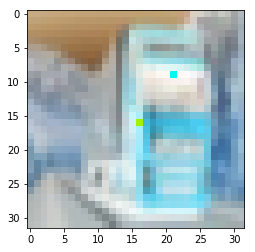

In [4]:
%matplotlib inline
result = extract_data(np.random.randint(1000), filepath='data/cifar-10-batches-bin/test_batch.bin')
plt.imshow(result['image'])

## Steps to use the TF Estimator APIs
1. Define dataset **metadata** and **global constants**
2. Define **data input function** to read the data from the source + **apply pre-processing**
3. Create TF **feature columns** based on metadata + **extended feature columns**
4. Instantiate a **model function** with the required **feature columns, EstimatorSpecs, & parameters**
5. Define a **serving function**
6. Run **Experiment** by supplying training and validation data, as well as required parameters
7. **Evaluate** the model using test data
8. Perform **predictions**

In [5]:
import math
import shutil
import tensorflow as tf

from datetime import datetime
from tensorflow.python.feature_column import feature_column

from tensorflow.contrib.learn import learn_runner
from tensorflow.contrib.learn import make_export_strategy

print(tf.__version__)

1.4.0


In [6]:
train_data_files = ['data/cifar-10-batches-bin/data_batch_{}.bin'.format(i) for i in range(1,5)]
valid_data_files = ['data/cifar-10-batches-bin/data_batch_5.bin']
test_data_files = ['data/cifar-10-batches-bin/test_batch.bin']

## 1. Define dataset metadata and global constants

In [7]:
# Process images of this size. Note that this differs from the original CIFAR
# image size of 32 x 32. If one alters this number, then the entire model
# architecture will change and any model would need to be retrained.
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

# If a model is trained with multiple GPUs, prefix all Op names with tower_name
# to differentiate the operations. Note that this prefix is removed from the
# names of the summaries when visualizing a model.
TOWER_NAME = 'tower'

# We use a weight decay of 0.0002, which performs better than the 0.0001 that
# was originally suggested.
WEIGHT_DECAY = 2e-4
MOMENTUM = 0.9

# Global constants describing model behaviors
MODEL_NAME = 'cnn-model-03'
USE_CHECKPOINT = False

## 2. Define Data Input Function

### a. parsing CIFAR-10 dataset

In [8]:
def parse_record(raw_record):
  # Every record consists of a label followed by the image, with a fixed number
  # of bytes for each.
  label_bytes = 1
  image_bytes = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH
  record_bytes = label_bytes + image_bytes
  
  # Convert from a string to a vector of uint8 that is record_bytes long.
  record_vector = tf.decode_raw(raw_record, tf.uint8)
  
  # The first byte represents the label, which we convert from uint8 to int32
  # and then to one-hot.
  label = tf.cast(record_vector[0], tf.int32)
  label = tf.one_hot(label, NUM_CLASSES)
  
  # The remaining bytes after the label represent the image, which we reshape
  # from [depth * height * width] to [depth, height, width].
  depth_major = tf.reshape(
    record_vector[label_bytes:record_bytes], [IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
  
  # Convert from [depth, height, width] to [height, width, depth], and cast as
  # float32.
  image = tf.cast(tf.transpose(depth_major, [1, 2, 0]), tf.float32)
  
  return image, label

### b. preprocessing CIFAR-10 dataset

In [9]:
def preprocess_image(image, is_training=False):
  """Preprocess a single image of layout [height, width, depth]."""
  if is_training:
    # Resize the image to add four extra pixels on each side.
    image = tf.image.resize_image_with_crop_or_pad(
        image, IMAGE_HEIGHT + 8, IMAGE_WIDTH + 8)

    # Randomly crop a [_HEIGHT, _WIDTH] section of the image.
    image = tf.random_crop(image, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])

    # Randomly flip the image horizontally.
    image = tf.image.random_flip_left_right(image)

  # Subtract off the mean and divide by the variance of the pixels.
  image = tf.image.per_image_standardization(image)
  return image

### c. data pipeline input function

In [10]:
def generate_input_fn(file_names,
                      mode=tf.estimator.ModeKeys.EVAL,
                      num_epochs=None,
                      batch_size=1):

  def _input_fn():
    label_bytes = 1
    image_bytes = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH
    record_bytes = label_bytes + image_bytes
    dataset = tf.data.FixedLengthRecordDataset(filenames=file_names,
                                               record_bytes=record_bytes)

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    if is_training:
      buffer_size = batch_size * 2 + 1
      dataset = dataset.shuffle(buffer_size=buffer_size)

    dataset = dataset.map(parse_record)
    dataset = dataset.map(lambda image, label: (preprocess_image(image, is_training), label))

    dataset = dataset.prefetch(2 * batch_size)

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)

    # Batch results by up to batch_size, and then fetch the tuple from the
    # iterator.
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    images, labels = iterator.get_next()

    features = {'images': images}
    return features, labels
  
  return _input_fn

## 3. Define Feature Columns

In [11]:
def get_feature_columns():
  feature_columns = {
    'images': tf.feature_column.numeric_column('images', (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)),
  }
  return feature_columns

In [12]:
feature_columns = get_feature_columns()
print("Feature Columns: {}".format(feature_columns))

Feature Columns: {'images': _NumericColumn(key='images', shape=(32, 32, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)}


## 4. Instantiate an Estimator

In [13]:
def get_model():
  model = tf.keras.models.Sequential()
  # Define input tensor in Keras world.
  model.add(tf.keras.layers.InputLayer(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH), name='images'))

  # The first convolutional layer.
  model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'))

  # The second convolutional layer.
  model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'))
  model.add(tf.keras.layers.Dropout(0.25))
    
  # The third convolutional layer
  model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    
  # The fourth convolutional layer
  model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
    
  model.add(tf.keras.layers.Flatten())
    
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(NUM_CLASSES))
  model.add(tf.keras.layers.Activation('softmax'))
  
  opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
  return model

## 5. Train, Evaluate and Export ML Models

### a. Set HParam and RunConfig

In [14]:
hparams = tf.contrib.training.HParams(
  batch_size=200,
  max_steps=100,
)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.contrib.learn.RunConfig(
  save_checkpoints_steps=200,
  tf_random_seed=19851211,
  model_dir=model_dir
)

### b. Define Serving Function

In [15]:
# Cannot use this
def serving_input_fn():

  receiver_tensor = {'images': tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32)}
  features = {'images': tf.map_fn(preprocess_image, receiver_tensor['images'])}
  
  return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

### c. Train and Evaluate

In [16]:
# Set learning phase as Training
tf.keras.backend.set_learning_phase(True)

# Get model defined with tf.keras
keras_model = get_model()

# Create estimator from keras model
estimator = tf.keras.estimator.model_to_estimator(
  keras_model=keras_model, model_dir=model_dir)

# TF.Keras seems not to support exporter...
exporter = None

train_spec = tf.estimator.TrainSpec(
  input_fn=generate_input_fn(file_names=train_data_files,
                             mode=tf.contrib.learn.ModeKeys.TRAIN,
                             batch_size=hparams.batch_size),
  max_steps=hparams.max_steps,
  hooks=None
)

eval_spec = tf.estimator.EvalSpec(
  input_fn=generate_input_fn(file_names=valid_data_files,
                             mode=tf.contrib.learn.ModeKeys.EVAL,
                             batch_size=hparams.batch_size),
  steps=50,
  name=None,
  hooks=None,
  exporters=exporter, # Iterable of Exporters, or single one or None.
  start_delay_secs=120,
  throttle_secs=600
)

INFO:tensorflow:Using the Keras model from memory.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f29067bebd0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'trained_models/cnn-model-03', '_save_summary_steps': 100}


In [17]:
#if not USE_CHECKPOINT:
#  print("Removing previous artifacts...")
#  shutil.rmtree(model_dir, ignore_errors=True)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Starting evaluation at 2017-11-30-03:33:13
INFO:tensorflow:Restoring parameters from trained_models/cnn-model-03/model.ckpt-100
INFO:tensorflow:Evaluation [1/50]
INFO:tensorflow:Evaluation [2/50]
INFO:tensorflow:Evaluation [3/50]
INFO:tensorflow:Evaluation [4/50]
INFO:tensorflow:Evaluation [5/50]
INFO:tensorflow:Evaluation [6/50]
INFO:tensorflow:Evaluation [7/50]
INFO:tensorflow:Evaluation [8/50]
INFO:tensorflow:Evaluation [9/50]
INFO:tensorflow:Evaluation [10/50]
INFO:tensorflow:Evaluation [11/50]
INFO:tensorflow:Evaluation [12/50]
INFO:tensorflow:Evaluation [13/50]
INFO:tensorflow:Evaluation [14/50]
INFO:tensorflow:Evaluation [15/50]
INFO:tensorflow:Evaluation [16/50]
INFO:tensorflow:Evaluat

## 6. Evaluate the Model

In [18]:
train_size = 1000
valid_size = 1000
test_size = 1000

train_input_fn = generate_input_fn(file_names=train_data_files,
                                   mode=tf.contrib.learn.ModeKeys.TRAIN,
                                   batch_size=train_size)

valid_input_fn = generate_input_fn(file_names=valid_data_files,
                                   mode=tf.contrib.learn.ModeKeys.EVAL,
                                   batch_size=valid_size)

test_input_fn = generate_input_fn(file_names=test_data_files,
                                  mode=tf.contrib.learn.ModeKeys.EVAL,
                                  batch_size=test_size)

train_results = estimator.evaluate(input_fn=train_input_fn, steps=1)
print("######################################################################################")
print("# {}".format(train_results))
print("######################################################################################")

valid_results = estimator.evaluate(input_fn=valid_input_fn, steps=1)
print("######################################################################################")
print("# {}".format(valid_results))
print("######################################################################################")

test_results = estimator.evaluate(input_fn=test_input_fn, steps=1)
print("######################################################################################")
print("# {}".format(test_results))
print("######################################################################################")

INFO:tensorflow:Starting evaluation at 2017-11-30-03:33:17
INFO:tensorflow:Restoring parameters from trained_models/cnn-model-03/model.ckpt-100
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-11-30-03:33:18
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.29, global_step = 100, loss = 1.95585
######################################################################################
# {'loss': 1.9558514, 'global_step': 100, 'accuracy': 0.28999999}
######################################################################################
INFO:tensorflow:Starting evaluation at 2017-11-30-03:33:18
INFO:tensorflow:Restoring parameters from trained_models/cnn-model-03/model.ckpt-100
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-11-30-03:33:19
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.311, global_step = 100, loss = 1.90885
######################################################################################


## 7. Prediction

### Note that this part doesn't work as intended, so please ignore this section.

In [19]:
####
# This cell doesn't work as intended.
####

export_dir = model_dir + '/export/Servo/'
saved_model_dir = export_dir + '1'

print("Removing previously exported model...")
shutil.rmtree(saved_model_dir, ignore_errors=True)

test_type = 0

if test_type == 0:
  """
  This way doesn't reflect tf.keras.backend.set_learning_phase(False)
  """

  tf.keras.backend.set_learning_phase(0)

  builder = tf.saved_model.builder.SavedModelBuilder(saved_model_dir)

  prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    inputs={'images': keras_model.input},
    outputs={'prediction': keras_model.output})

  with tf.keras.backend.get_session() as sess:
    builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
          prediction_signature,
      })
    builder.save()
elif test_type == 1:
  """
  This way reflects tf.keras.backend.set_learning_phase(False)
  """

  tf.keras.backend.set_learning_phase(False)

  config = keras_model.get_config()
  weights = keras_model.get_weights()
  export_model = tf.keras.models.Sequential.from_config(config)
  export_model.set_weights(weights)

  builder = tf.saved_model.builder.SavedModelBuilder(saved_model_dir)

  prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    inputs={'images': export_model.input},
    outputs={'prediction': export_model.output})

  with tf.keras.backend.get_session() as sess:
    builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
          prediction_signature,
      })
    builder.save()

# Create predictor function
predictor_fn = tf.contrib.predictor.from_saved_model(
  export_dir = saved_model_dir,
  signature_def_key=tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY)

Removing previously exported model...
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: trained_models/cnn-model-03/export/Servo/1/saved_model.pb
INFO:tensorflow:Restoring parameters from trained_models/cnn-model-03/export/Servo/1/variables/variables


In [20]:
def per_image_standardization(image):
  """
  This is copy of tf.image.per_image_standardization
  """
  image_mean = np.mean(image)
  num_pixels = image.size
  variance = (np.mean(image ** 2) - (image_mean ** 2))
  variance = np.maximum(variance, 0)
  stddev = np.sqrt(variance)
  min_stddev = 1.0/np.sqrt(num_pixels)

  pixel_value_scale = np.max([stddev, min_stddev])
  pixel_value_offset = image_mean
  image = image - pixel_value_offset
  image = image / pixel_value_scale
  return image

def get_accuracy_via_predictor_function(predictor_fn,
                                        N=1000,
                                        filepath='data/cifar-10-batches-bin/test_batch.bin'):
  labels = []
  images = []

  for i in range(N):
    result = extract_data(i, filepath='data/cifar-10-batches-bin/test_batch.bin')
    images.append(per_image_standardization(result['image']))
    labels.append(result['label'][0])

  output = predictor_fn(
    {
      'images': images,
    }
  )
  
  return output['prediction'], np.sum([a==r for a, r in zip(labels, np.argmax(output['prediction'], axis=1))]) / float(N)

In [21]:
# OMG, accuracy is just the same as random predictions....
# This might be caused by initialized weights. but how we can properly load learned weights?
outputs_, accuracy = get_accuracy_via_predictor_function(predictor_fn=predictor_fn, N=1000)
print(accuracy)

0.107


In [48]:
outputs = []
N = 1000

test_results = estimator.predict(input_fn=test_input_fn)
for i, output in enumerate(test_results):
  if i == N:
    break
  outputs.append(output['activation_1'])
  
labels = []
for i in range(N):
  result = extract_data(i, filepath='data/cifar-10-batches-bin/test_batch.bin')
  labels.append(result['label'][0])
  
np.sum([a==r for a, r in zip(labels, np.argmax(outputs, axis=1))]) / float(N)

INFO:tensorflow:Restoring parameters from trained_models/cnn-model-03/model.ckpt-100


0.34399999999999997

In [22]:
image = extract_data(0)['image']

In [30]:
sess = tf.InteractiveSession()
A = tf.image.per_image_standardization(tf.constant(image)).eval()
B = per_image_standardization(image)
sess.close()

In [28]:
(A - B).sum()

-1.3876706e-07

## 8. TensorBoard

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start(model_dir)

In [ ]:
for pid in TensorBoard.list()['pid']:
    TensorBoard().stop(pid)
    print 'Stopped TensorBoard with pid {}'.format(pid)

## (Optional) Using gRPC to get prediction

In [ ]:
from __future__ import print_function

from grpc.beta import implementations
import numpy
import tensorflow as tf

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2

def predict_with_grpc():
  """                                                                                                                                     
  Note that you are running TensorFlow Serving with below commands.                                                                       
  tensorflow_model_server --port=9000 --model_name=cnn-model-01 --model_base_path=./cnn-model-01                                          

  In addition, make sure cnn-model-01 directory is organized as follows:                                                                  

  cnn-model-01/:                                                                                                                          
  {random_value}                                                                                                                              

  cnn-model-01/{randam_value}/:                                                                                                           
  saved_model.pb  variables                                                                                                               
  """
  host = 'localhost'
  port = '9000'
  channel = implementations.insecure_channel(host, int(port))
  stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)

  result = extract_data(0)
  request = predict_pb2.PredictRequest()
  request.model_spec.name = 'cnn-model-01'
  request.model_spec.signature_name = 'predictions'
  image = result['image']
  label = result['label']
  request.inputs['images'].CopyFrom(
      tf.contrib.util.make_tensor_proto(image, shape=[1, 32, 32, 3]))

  result_future = stub.Predict.future(request, 5.0)
  print(result_future.result().outputs['classes'].int64_val)
  print(result_future.result().outputs['probabilities'].float_val)